# Análisis de datos sobre recomendaciones de portafolios por ZZAlpha Ltd

_Preparado por Julio César Gutiérrez Muñoz_.

Fuente de datos: [UCI Machine Learning Repository - ZZAlpha Ltd. Stock Recommendations 2012-2014](https://archive.ics.uci.edu/ml/datasets/Machine+Learning+based+ZZAlpha+Ltd.+Stock+Recommendations+2012-2014)

Las librerías necesarias para la correcta ejecución de este notebook son:

- Pandas
- Matplotlib
- PySpark
- Pymongo

Nota: Este notebook esta disponible en [Github](https://github.com/ZzAntares/stock-recommendations-analysis).

## Estructura de los datos

El dataset se compone de tres carpetas las cuales contienen 250, 252 y 253 archivos respectivamente:

In [217]:
!tree -L 2 --filelimit 3 portfolio-recommendations

portfolio-recommendations
├── sNewsListWResults2012 [250 entries exceeds filelimit, not opening dir]
├── sNewsListWResults2013 [252 entries exceeds filelimit, not opening dir]
└── sNewsListWResults2014 [253 entries exceeds filelimit, not opening dir]

3 directories, 0 files


El número de lineas contenidas en cada archivo varía así como su estructura, en total el dataset contiene 482,016 portafolios con recomendaciónes de inversión realizadas por ZZAlpha Ltd entre el 2011 y el 2014:

In [218]:
!find portfolio-recommendations/ -name '*.txt' -type f | xargs wc -l | grep total | xargs echo "No. lines:"

No. lines: 482016 total


Dichas recomendaciones están organizadas en portafolios de diferentes tamaños (entre 1 y 20 stocks c/u), cuando estas recomendaciones se toman en cuenta individualmente se observa que se realizaron un total de 3,467,030 de operaciones en el periodo mencionado.

Cada linea tiene una estructura similar a la siguiente:

```
Jan 04 2005_006 Big_100_5_LONG_SHORT_F.pdf, L, AA 0.959 =25.97/27.09, AMAT 0.950 =14.70/15.46, EBAY 0.930=53.33/57.31, PFE 0.995 =19.84/19.95, UPS 0.980 =71.72/73.16, Avg of 5 = 0.963
```

> The above indicates recommendations were made before market open on **Jan 4, 2005**. This portfolio was limited to the biggest **100 cap stocks** and was of **size 5**. It was for **'L'** or long recommendations. The **five stocks recommended are shown by ticker, result, price at sale divided by price at purchase**. The **average for the five is shown**.

Se define la función mapper que transforma cada linea en una estructura más ordenada que puede ser exportada a CSV fácilmente.

#### Sample Input

```
'Jul 09 2012_140 Cap_1-5B_20_LONG_F.pdf, L, AGP 1.000 =missing,AIZ 0.987 =34.40/34.86,BPOP 1.007 =16.21/16.10,CCO 0.830 =4.75/5.72,CNC 1.104 =35.71/32.36,DWA 1.001 =19.32/19.31,GEF 1.014 =41.88/41.30,HGSI 1.046 =14.22/13.59,HNT 1.018 =26.30/25.83,IOC 1.064 =74.44/69.94,JEF 0.997 =12.67/12.71,JNS 0.959 =7.23/7.54,KCG 0.994 =11.77/11.84,MAKO 1.000 =missing,OPEN 0.995 =38.74/38.94,PL 0.986 =29.61/30.03,SFG 0.990 =37.31/37.70,SINA 0.969 =49.04/50.60,STSA 0.996 =19.29/19.37,TRGP 1.058 =44.74/42.27, Avg of 18 = 1.001'
```

#### Sample Output

```
('2012-07-09 00:00:00', 'Cap_1-5B_20_LONG_F', 'L', '1.001', 'AGP:1.000:*:*', 'AIZ:0.987:34.40:34.86', 'BPOP:1.007:16.21:16.10', 'CCO:0.830:4.75:5.72', 'CNC:1.104:35.71:32.36', 'DWA:1.001:19.32:19.31', 'GEF:1.014:41.88:41.30', 'HGSI:1.046:14.22:13.59', 'HNT:1.018:26.30:25.83', 'IOC:1.064:74.44:69.94', 'JEF:0.997:12.67:12.71', 'JNS:0.959:7.23:7.54', 'KCG:0.994:11.77:11.84', 'MAKO:1.000:*:*', 'OPEN:0.995:38.74:38.94', 'PL:0.986:29.61:30.03', 'SFG:0.990:37.31:37.70', 'SINA:0.969:49.04:50.60', 'STSA:0.996:19.29:19.37', 'TRGP:1.058:44.74:42.27')
```

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark import SparkContext
from dateutil import parser
from pymongo import MongoClient

In [220]:
SparkContext.setSystemProperty('spark.executor.memory', '2g')
sc = SparkContext.getOrCreate()

dataset = sc.textFile('portfolio-recommendations/*/*.txt')

In [221]:
sc._conf.getAll()

[('spark.app.id', 'local-1512587159235'),
 ('spark.executor.memory', '2g'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '10.13.8.32'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '56474'),
 ('spark.app.name', 'pyspark-shell')]

In [222]:
def transform(line):
    data = list(map(str.strip, line.split(',')))
    
    if len(data) < 3:
        return 'missing'
    
    if 'Avg of 0' in data[-1]:
        return 'missing'
    
    report_info, operation, *stocks, avg = data
    
    # Extract date and name from report title
    report_date_code, report_name = report_info.rsplit(' ', 1)
    report_date = parser.parse(report_date_code.split('_')[0])
    
    # Extract average value
    average = avg.split('=')[1].strip()
    # average = average if average.isdigit() else '*'
    if not average.isdigit():
        print(average)
    
    # Format tickers (Remove '=', '/', ' ')
    stocks = [
        s.replace('=', '', 1).replace('/', ':', 1) \
        .replace(' ', ':').replace('missing', '*:*') \
        for s in stocks
    ]
    
    return '{rdate},{rname},{op},{avg},{stocks}'.format(
        rdate=str(report_date),
        rname=report_name[:-4],
        op=operation,
        avg=average,
        stocks=','.join(stocks))

In [223]:
ds = dataset.map(transform)
ds.saveAsTextFile('alpha-recommendations')

Después de la transformación combinamos todos los diferentes archivos producidos por pyspark en uno solo `alpha-recommendations.csv` y eliminamos aquellos registros mal formados (_missing_):

In [224]:
!cat alpha-recommendations/* | gsed '/missing/d' > alpha-recommendations.csv
!head -n5 alpha-recommendations.csv

2012-03-27 00:00:00,Big_100_1_LONG_SHORT_F,L,1.007,PM:1.007:88.79:88.14
2012-03-27 00:00:00,Big_100_1_LONG_SHORT_F,S,0.990,V:0.990:118.84:119.98
2012-03-27 00:00:00,Big_100_2_LONG_SHORT_F,L,0.993,PM:1.007:88.79:88.14,VZ:0.979:37.95:38.76
2012-03-27 00:00:00,Big_100_2_LONG_SHORT_F,S,0.994,V:0.990:118.84:119.98,WMT:0.997:61.14:61.35
2012-03-27 00:00:00,Big_100_5_LONG_SHORT_F,L,0.994,APA:0.992:100.58:101.42,F:1.016:12.71:12.51,OXY:0.978:97.49:99.73,PM:1.007:88.79:88.14,VZ:0.979:37.95:38.76


## Almacenamiento de los datos

Para almacenar los datos de manera estructurada utilizamos MongoDB. A continuación se define el script que carga los datos de CSV a MongoDB:

In [2]:
conn = MongoClient()
db = conn.alpha

In [226]:
with open('alpha-recommendations.csv', 'r') as f:
    reader = csv.reader(f)

    for i, line in enumerate(reader):
        date, name, operation, average, *stocks = line
        size = len(stocks)
        
        recommendations = []
        for stock in stocks:
            ticker, roe, sold_at, bought_at = filter(None, stock.split(':'))

            recommendations.append({
                'ticker': ticker,
                'result': roe,
                'price_at_sale': sold_at,
                'price_at_purchase': bought_at
            })
            
        db.recommendations.insert_one({
            'date': date,
            'portfolio': name,
            'rid': i,
            'position': operation,
            'avg_result': average,
            'recommendations': size,
            'stocks': recommendations
        })

## Consultas y Agregaciones

In [4]:
def printer(res):
    for r in res:
        print(r)

### ¿Cuántos portafolios diferentes se recomendaron?

In [158]:
result = db.recommendations.aggregate([
    { '$group': { '_id': '$portfolio' } },
    { '$count': 'Unique portfolios' }
])

printer(result)

{'Unique portfolios': 438}


### ¿De cuantos stocks se componen los diferentes portafolios que se recomendaron?

In [160]:
result = db.recommendations.aggregate([
    { '$group': { '_id': '$recommendations' } },
    { '$sort': { '_id': -1 } }
])

printer(result)

{'_id': 20}
{'_id': 19}
{'_id': 18}
{'_id': 17}
{'_id': 16}
{'_id': 15}
{'_id': 14}
{'_id': 13}
{'_id': 12}
{'_id': 11}
{'_id': 10}
{'_id': 9}
{'_id': 8}
{'_id': 7}
{'_id': 6}
{'_id': 5}
{'_id': 4}
{'_id': 3}
{'_id': 2}
{'_id': 1}


### ¿Cuántas posiciones Long se recomendaron? ¿Cuántas fueron Short?

In [162]:
result = db.recommendations.aggregate([
    { '$match': { 'position': 'L' } },
    { '$count': 'Long positions' }
])

printer(result)

{'Long positions': 320840}


In [163]:
result = db.recommendations.aggregate([
    { '$match': { 'position': 'S' } },
    { '$count': 'Short positions' }
])

printer(result)

{'Short positions': 160421}


### ¿Cuántas recomendaciones fueron exitosas? ¿Cuántas fueron equivocadas?

In [164]:
result = db.recommendations.aggregate([
    { '$match': { 'avg_result': { '$gt': '1' } } },
    { '$count': 'Successful recommendations' }
])

printer(result)

{'Successful recommendations': 266357}


In [166]:
result = db.recommendations.aggregate([
    { '$match': { 'avg_result': { '$lt': '1' } } },
    { '$count': 'Wrong recommendations' }
])

printer(result)

{'Wrong recommendations': 214904}


### ¿Cuál fue la recomendación con el mejor resultado? ¿Cuál con el peor resultado?

In [233]:
result = db.recommendations.aggregate([
    { '$sort': { 'avg_result': -1 } },
    { '$limit': 1 }
])

printer(result)

{'_id': ObjectId('5a2ac400a4ce83963e470bd9'), 'date': '2014-06-25 00:00:00', 'portfolio': 'S12-Util_1_LONG_SHORT_F', 'rid': 461359, 'position': 'L', 'avg_result': '3.109', 'recommendations': 1, 'stocks': [{'ticker': 'USU', 'result': '3.109', 'price_at_sale': '8.55', 'price_at_purchase': '2.75'}]}


In [234]:
result = db.recommendations.aggregate([
    { '$sort': { 'avg_result': 1 } },
    { '$limit': 1 }
])

printer(result)

{'_id': ObjectId('5a2ac342a4ce83963e416a9f'), 'date': '2012-08-31 00:00:00', 'portfolio': 'Cap_2-250m_1_LONG_SHORT_F', 'rid': 92405, 'position': 'L', 'avg_result': '0.236', 'recommendations': 1, 'stocks': [{'ticker': 'DDMG', 'result': '0.236', 'price_at_sale': '0.55', 'price_at_purchase': '2.33'}]}


## Visualización de datos

A continuación se cargan los datos en un DataFrame de Pandas para su posterior manejo:

In [8]:
result = db.recommendations.aggregate([
    { '$unwind': '$stocks' },
    { '$project': {
        '_id': 0,
        'date': 1,
        'portfolio': 1,
        'pid': '$rid',
        'avg_result': 1,
        'position': 1,
        'recommendations': 1,
        'ticker': '$stocks.ticker',
        'result': '$stocks.result',
        'price_at_sale': '$stocks.price_at_sale',
        'price_at_purchase': '$stocks.price_at_purchase'
       }
     }
])

recommendations = pd.DataFrame(list(result))

In [9]:
recommendations.tail()

,avg_result,date,pid,portfolio,position,price_at_purchase,price_at_sale,recommendations,result,ticker
3467026,0.991,2014-04-09 00:00:00,480950,Double_Diamond_5_LONG_F,L,148.25,147.17,5,0.993,ALXN
3467027,0.991,2014-04-09 00:00:00,480950,Double_Diamond_5_LONG_F,L,32.64,32.60,5,0.999,HPQ
3467028,0.991,2014-04-09 00:00:00,480950,Double_Diamond_5_LONG_F,L,7.12,7.13,5,1.001,PLUG
3467029,0.991,2014-04-09 00:00:00,480950,Double_Diamond_5_LONG_F,L,3.08,3.09,5,1.003,SIRI
3467030,0.991,2014-04-09 00:00:00,480950,Double_Diamond_5_LONG_F,L,72.00,69.15,5,0.960,SNX


In [12]:
# Convert string values to numerical
recommendations['avg_result'] = recommendations['avg_result'].astype('float64')
recommendations['result'] = recommendations['result'].astype('float64')

recommendations['price_at_purchase'].replace('*', np.nan, inplace=True)
recommendations['price_at_sale'].replace('*', np.nan, inplace=True)

recommendations['price_at_purchase'] = recommendations['price_at_purchase'].astype('float64')
recommendations['price_at_sale'] = recommendations['price_at_sale'].astype('float64')

recommendations.dtypes

avg_result           float64
date                  object
pid                    int64
portfolio             object
position              object
price_at_purchase    float64
price_at_sale        float64
recommendations        int64
result               float64
ticker                object
dtype: object

In [13]:
recommendations.avg_result.describe().reset_index().style.format({'avg_result': '{:.4f}'})

,index,avg_result
0,count,3467031.0000
1,mean,1.0031
2,std,0.0341
3,min,0.2360
4,25%,0.9860
5,50%,1.0040
6,75%,1.0200
7,max,3.1090


In [14]:
recommendations.avg_result.max()

3.109

ZZAlpha realizó sus recomendaciones publicando portafolios de un tamaño estándar (1, 2, 5, 10 y 20 stocks), a continuación se muestra la distribución de las recomendaciones hechas por el tamaño del portafolio.

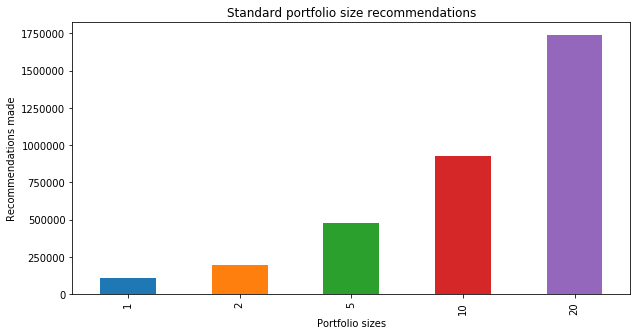

In [15]:
portfolios = recommendations.groupby('recommendations').size()
portfolios[[1, 2, 5, 10, 20]].plot(kind='bar', title='Standard portfolio size recommendations', figsize=(10, 5))
plt.xlabel('Portfolio sizes')
plt.ylabel('Recommendations made')
plt.show()

Se realizaron recomendaciones para portafolios de tamaños no estándar pero estos son relativamente pocos cuando se compara a las recomendaciones que se hicieron para portafolios estándar. A continuación se muestra la distribución de recomendaciones en portafolios no estándar.

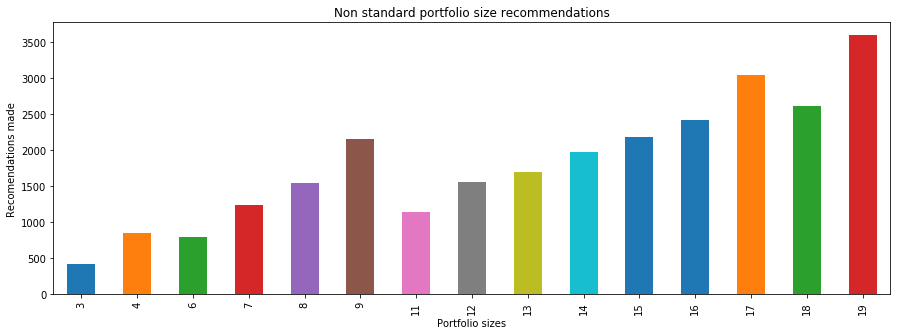

In [38]:
portfolios.drop([1, 2, 5, 10, 20]).plot(kind='bar', title='Non standard portfolio size recommendations', figsize=(15, 5))
plt.xlabel('Portfolio sizes')
plt.ylabel('Recomendations made')
plt.show()

También se observa que la mayoría de las recomendaciones fueron posiciones Long (compra de stock) siendo casi el doble de las posiciones Short recomendadas.

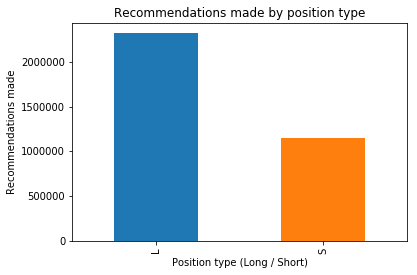

In [84]:
recommendations.groupby('position').size().plot(kind='bar', title='Recommendations made by position type')
plt.xlabel('Position type (Long / Short)')
plt.ylabel('Recommendations made')
plt.show()

Se genera la columna "_outcome_" la cuál servirá para agrupar las recomendaciones por _exitosas_, _neutras_ y _erróneas_.

In [16]:
def outcome_generator(el):
    if el == 1:
        return 'unchanged'
    elif el > 1:
        return 'successful'
    elif el < 1:
        return 'unsuccessful'
    else:
        return None

recommendations['outcome'] = recommendations['result'].apply(outcome_generator)
recommendations.head()

,avg_result,date,pid,portfolio,position,price_at_purchase,price_at_sale,recommendations,result,ticker,outcome
0,1.007,2012-03-27 00:00:00,0,Big_100_1_LONG_SHORT_F,L,88.14,88.79,1,1.007,PM,successful
1,0.990,2012-03-27 00:00:00,1,Big_100_1_LONG_SHORT_F,S,119.98,118.84,1,0.990,V,unsuccessful
2,0.993,2012-03-27 00:00:00,2,Big_100_2_LONG_SHORT_F,L,88.14,88.79,2,1.007,PM,successful
3,0.993,2012-03-27 00:00:00,2,Big_100_2_LONG_SHORT_F,L,38.76,37.95,2,0.979,VZ,unsuccessful
4,0.994,2012-03-27 00:00:00,3,Big_100_2_LONG_SHORT_F,S,119.98,118.84,2,0.990,V,unsuccessful


Analizamos el porcentaje de efectividad de las recomendaciones realizada por la firma:

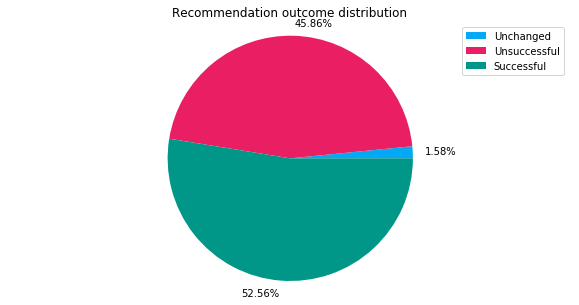

In [58]:
outcomes.plot(
    kind='pie',
    figsize=(10, 5),
    title='Recommendation outcome distribution',
    colors=['#03A9F4', '#E91E63', '#009688'],
    labels=map('{:.2f}%'.format, outcomes.values / len(recommendations) * 100)
)

plt.legend(list(map(str.capitalize, outcomes.index.values)))
plt.ylabel('')
plt.axis('equal')
plt.show()

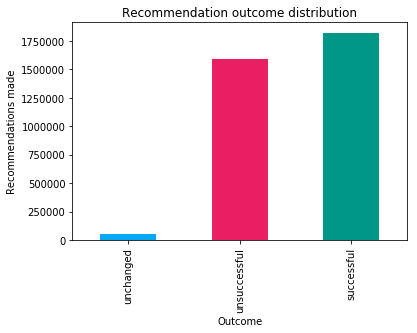

In [31]:
outcomes.plot(
    kind='bar',
    title='Recommendation outcome distribution',
    color=['#03A9F4', '#E91E63', '#009688'])

plt.xlabel('Outcome')
plt.ylabel('Recommendations made')
plt.show()

La efectividad de la recomendación por el tipo de posición:

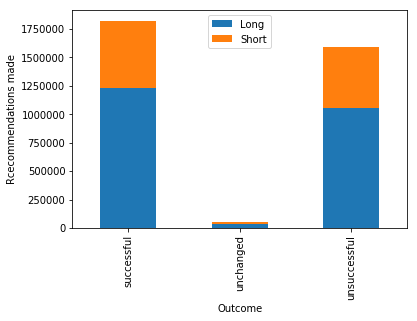

In [26]:
recommendations.groupby(['outcome', 'position']).size().unstack().plot(kind='bar', stacked=True)
plt.legend(['Long', 'Short'])
plt.xlabel('Outcome')
plt.ylabel('Rcecommendations made')
plt.show()

Aqui se observa cuales son los top 3 portafolios con el mejor resultado y la fecha en la que se hizo la recomendación:

In [124]:
recommendations.sort_values('avg_result', ascending=False)[['pid', 'avg_result', 'date', 'portfolio']].head(3)

,pid,avg_result,date,portfolio
3323065,461359,3.109,2014-06-25 00:00:00,S12-Util_1_LONG_SHORT_F
3325768,461731,3.109,2014-06-25 00:00:00,S12-Util_1_LONG_F
2147345,300926,3.081,2013-07-16 00:00:00,S12-Util_1_LONG_SHORT_F


Y el top 3 de los portafolios con el peor resultado:

In [126]:
recommendations.sort_values('avg_result')[['pid', 'avg_result', 'date', 'portfolio']].head(3)

,pid,avg_result,date,portfolio
653561,92425,0.236,2012-08-31 00:00:00,Cap_20-1000m_1_LONG_SHORT_F
653409,92405,0.236,2012-08-31 00:00:00,Cap_2-250m_1_LONG_SHORT_F
656101,92789,0.236,2012-08-31 00:00:00,Cap_2-250m_1_LONG_F


El ratio de recomendaciones exitosas y erroneas se mantiene independientemente del tamaño del portafolio:

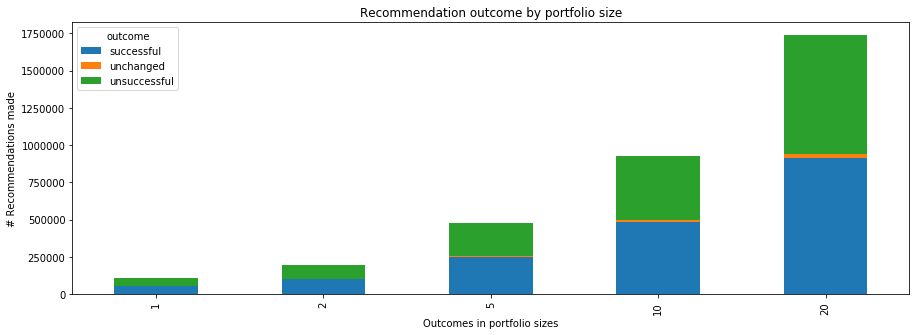

In [146]:
by_portfolio = recommendations[recommendations['recommendations'].isin([1, 2, 5, 10, 20])] \
    .groupby(['recommendations', 'outcome']).size().unstack()
    
by_portfolio.plot(kind='bar', stacked=True, title='Recommendation outcome by portfolio size', figsize=(15, 5))

plt.xlabel('Outcomes in portfolio sizes')
plt.ylabel('# Recommendations made')
plt.show()

Se observa que el stocks más recomendado en los portafolios fue AAPL:

In [60]:
stocks = recommendations.groupby('ticker')
print('Number of unique stocks recommended:', len(stocks))

Number of unique stocks recommended: 4837


In [68]:
top_stocks = stocks.size().sort_values(ascending=False)
top_stocks.head(10)

ticker
AAPL    12949
HPQ     11958
DB      11909
PCLN    10902
AMZN    10096
GNW      9900
PXD      9737
AFL      8380
UBS      8336
HNT      8274
dtype: int64

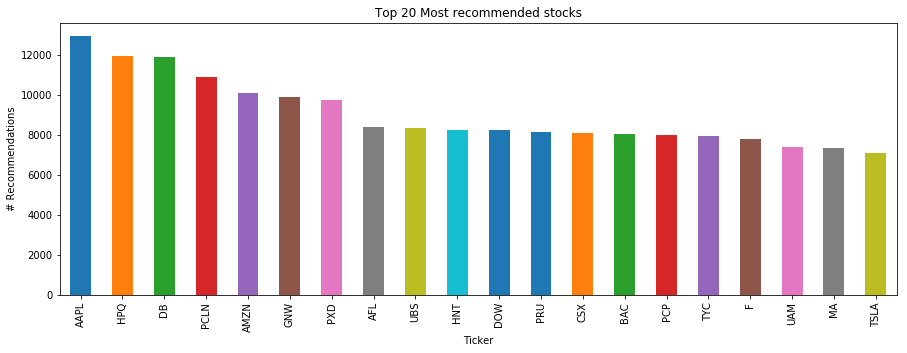

In [69]:
top_stocks.head(20).plot(
    kind='bar',
    figsize=(15, 5),
    title='Top 20 Most recommended stocks'
)

plt.xlabel('Ticker')
plt.ylabel('# Recommendations')
plt.show()

In [70]:
recommendations['date'] = pd.to_datetime(recommendations.date)

In [71]:
recommendations = recommendations.set_index('date')

In [73]:
recommendations.head(3)

,avg_result,pid,portfolio,position,price_at_purchase,price_at_sale,recommendations,result,ticker,outcome
date,,,,,,,,,,
2012-03-27,1.007,0,Big_100_1_LONG_SHORT_F,L,88.14,88.79,1,1.007,PM,successful
2012-03-27,0.990,1,Big_100_1_LONG_SHORT_F,S,119.98,118.84,1,0.990,V,unsuccessful
2012-03-27,0.993,2,Big_100_2_LONG_SHORT_F,L,88.14,88.79,2,1.007,PM,successful


Cantidad de recomendaciones a través de los años:

In [77]:
active_recommendations = recommendations[recommendations.index.year != 2015]

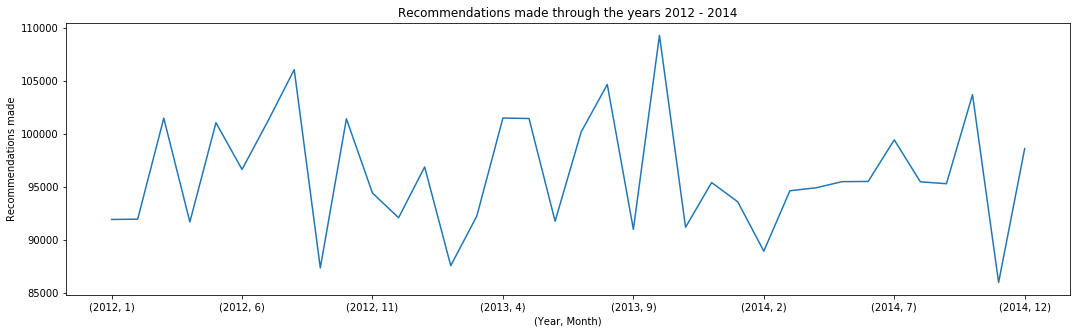

In [78]:
active_recommendations.groupby([active_recommendations.index.year, active_recommendations.index.month]).size().plot(title='Recommendations made through the years 2012 - 2014', figsize=(18, 5))
plt.xlabel('(Year, Month)')
plt.ylabel('Recommendations made')
plt.show()

Cantidad de recomendaciones exitosas a través de los años

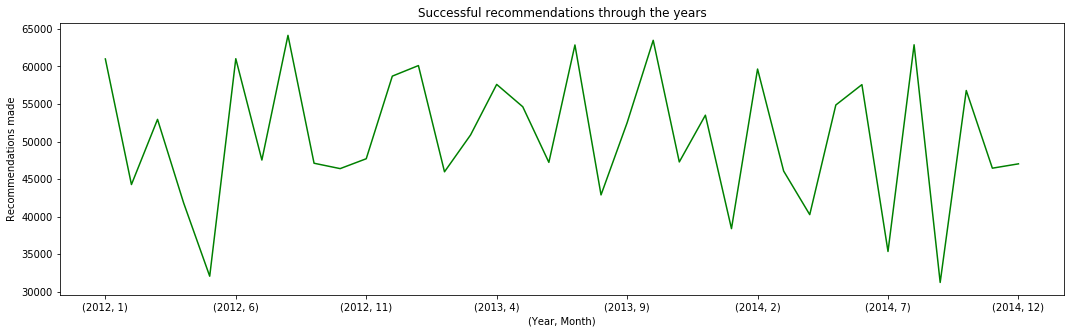

In [79]:
sr = active_recommendations[active_recommendations.outcome == 'successful']
sr.groupby([sr.index.year, sr.index.month]).size().plot(title='Successful recommendations through the years', figsize=(18, 5), color='green')

plt.xlabel('(Year, Month)')
plt.ylabel('Recommendations made')
plt.show()

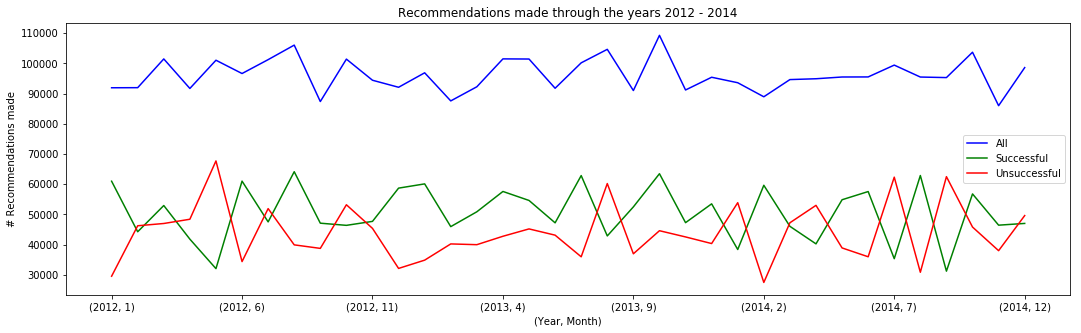

In [88]:
ax = active_recommendations.groupby([
    active_recommendations.index.year, active_recommendations.index.month
]).size().plot(figsize=(18, 5), color='blue')

sr = active_recommendations[active_recommendations.outcome == 'successful']
fr = active_recommendations[active_recommendations.outcome == 'unsuccessful']

sr.groupby([sr.index.year, sr.index.month]).size().plot(ax=ax, figsize=(18, 5), color='green')
fr.groupby([fr.index.year, fr.index.month]).size().plot(ax=ax, figsize=(18, 5), color='red')

plt.legend(['All', 'Successful', 'Unsuccessful'])
plt.title('Recommendations made through the years 2012 - 2014')
plt.ylabel('# Recommendations made')
plt.xlabel('(Year, Month)')
plt.show()

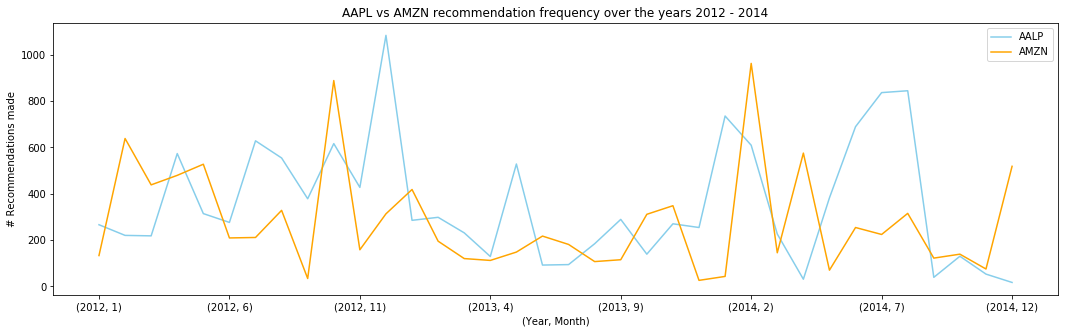

In [101]:
aapl = active_recommendations[active_recommendations.ticker == 'AAPL']
ax = aapl.groupby([aapl.index.year, aapl.index.month]).size().plot(figsize=(18, 5), color='skyblue')

amzn = active_recommendations[active_recommendations.ticker == 'AMZN']
amzn.groupby([amzn.index.year, amzn.index.month]).size().plot(ax=ax, figsize=(18, 5), color='orange')

plt.title('AAPL vs AMZN recommendation frequency over the years 2012 - 2014')
plt.legend(['AALP', 'AMZN'])
plt.ylabel('# Recommendations made')
plt.xlabel('(Year, Month)')
plt.show()